In [1]:
# http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
# https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt

from fastai.vision import *
from fastai.metrics import accuracy_thresh
from fastai.basic_data import *

from fastai.callbacks.hooks import num_features_model, model_sizes
from fastai.layers import BCEWithLogitsFlat
from fastai.basic_train import Learner
from fastai.utils.collect_env import *

from torch.utils.data import DataLoader, Dataset
from torch import nn

from skimage.util import montage
import pandas as pd

from torch import optim
import re

from functional import seq

from utils import *

In [4]:
show_install()



```text
=== Software === 
python        : 3.7.0
fastai        : 1.0.40.dev0
fastprogress  : 0.1.18
torch         : 1.0.0
nvidia driver : 396.54
torch cuda    : 9.0.176 / is available
torch cudnn   : 7401 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 8116MB | GeForce GTX 1080

=== Environment === 
platform      : Linux-4.15.0-43-generic-x86_64-with-debian-buster-sid
distro        : Ubuntu 18.04 Bionic Beaver
conda env     : fastai_updated
python        : /home/dollofcuty/anaconda3/envs/fastai_updated/bin/python
sys.path      : 
/media/dollofcuty/E604249504246B2F/Users/chrun/Documents/Projects/Machine Learning/unstructured data/whale-identification
/home/dollofcuty/anaconda3/envs/fastai_updated/lib/python37.zip
/home/dollofcuty/anaconda3/envs/fastai_updated/lib/python3.7
/home/dollofcuty/anaconda3/envs/fastai_updated/lib/python3.7/lib-dynload
/home/dollofcuty/anaconda3/envs/fastai_updated/lib/python3.7/site-packages
/home/dollofcuty/fastai
/home/do

In [5]:
# import fastai
# from fastprogress import force_console_behavior
# import fastprogress
# fastprogress.fastprogress.NO_BAR = True
# master_bar, progress_bar = force_console_behavior()
# fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar

Posing the problem as a classification task is probably not ideal. We are asking our NN to learn to recognize a whale out of 5004 possible candidates based on what it has learned about the whales. That is a tall order.

Instead, here we will try to pose the problem as a verification task. When presented with two images of whale flukes, we will ask the network - are the images of the same whale or of different whales? In particular, we will try to teach our network to learn features that can be useful in determining the similarity between whale images (hence the name of this approach - feature learning).

This seems like a much easier task, at least in theory. Either way, no need to start with a relatively big CNN like resnet50. Let's see what mileage we can get out of resnet18.

In [6]:
# new architecture calls for a new validation set, this time our validation set will consist of all whales that have exactly two images
df = pd.read_csv('data/train.csv')
im_count = df[df.Id != 'new_whale'].Id.value_counts()
im_count.name = 'sighting_count'
df = df.join(im_count, on='Id')
val_fns = set(df[df.sighting_count == 2].Image)

In [7]:
df.head()

,Image,Id,sighting_count
0,0000e88ab.jpg,w_f48451c,14.0
1,0001f9222.jpg,w_c3d896a,4.0
2,00029d126.jpg,w_20df2c5,4.0
3,00050a15a.jpg,new_whale,NaN
4,0005c1ef8.jpg,new_whale,NaN
5,0006e997e.jpg,new_whale,NaN
6,000a6daec.jpg,w_dd88965,16.0
7,000f0f2bf.jpg,new_whale,NaN
8,0016b897a.jpg,w_64404ac,5.0
9,001c1ac5f.jpg,w_a6f9d33,2.0


In [7]:
len(val_fns)

2570

In [8]:
fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

name = f'res18-siamese'

In [9]:
SZ = 224
BS = 64
NUM_WORKERS = 8
SEED=0

In [10]:
# data_block api creates categories based on classes it sees in the train set and
# our val set contains whales whose ids do not appear in the train set
classes = df.Id.unique()

In [11]:
data = (
    ImageItemList
        .from_df(df[df.Id != 'new_whale'], f'data/train-{SZ}', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-{SZ}'))
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
)

I am still using the ImageItemList even though I will create my own datasets. Why? Because I want to reuse the functionality that is already there (creating datasets from files, augmentations, resizing, etc).

I realize the code is neither clean nor elegant but for the time being I am happy with this approach.

In [2]:
def is_even(num): return num % 2 == 0

class TwoImDataset(Dataset):
    def __init__(self, ds):
        self.ds = ds
        self.whale_ids = ds.y.items
    def __len__(self):
        return 2 * len(self.ds)
    def __getitem__(self, idx):
        if is_even(idx):
            return self.sample_same(idx // 2)
        else: return self.sample_different((idx-1) // 2)
    def sample_same(self, idx):
        whale_id = self.whale_ids[idx]        
        candidates = list(np.where(self.whale_ids == whale_id)[0])
        candidates.remove(idx) # dropping our current whale - we don't want to compare against an identical image!
        
        if len(candidates) == 0: # oops, there is only a single whale with this id in the dataset
            return self.sample_different(idx)
        
        np.random.shuffle(candidates)
        return self.construct_example(self.ds[idx][0], self.ds[candidates[0]][0], 1)
    def sample_different(self, idx):
        whale_id = self.whale_ids[idx]
        candidates = list(np.where(self.whale_ids != whale_id)[0])
        np.random.shuffle(candidates)
        return self.construct_example(self.ds[idx][0], self.ds[candidates[0]][0], 0)
    
    def construct_example(self, im_A, im_B, class_idx):
        return [im_A, im_B], class_idx

NameError: name 'Dataset' is not defined

In [3]:
train_dl = DataLoader(
    TwoImDataset(data.train),
    batch_size=BS,
    shuffle=True,
    num_workers=NUM_WORKERS
)
valid_dl = DataLoader(
    TwoImDataset(data.valid),
    batch_size=BS,
    shuffle=False,
    num_workers=NUM_WORKERS
)

data_bunch = ImageDataBunch(train_dl, valid_dl)

NameError: name 'DataLoader' is not defined

In [14]:
def normalize_batch(batch):
    stat_tensors = [torch.tensor(l).cuda() for l in imagenet_stats]
    return [normalize(batch[0][0], *stat_tensors), normalize(batch[0][1], *stat_tensors)], batch[1]

In [15]:
data_bunch.add_tfm(normalize_batch)

In [16]:
arch = models.resnet18

In [17]:
class SiameseNetwork(nn.Module):
    def __init__(self, arch=arch):
        super().__init__() 
        self.cnn = create_body(arch)        
        #self.head = create_head(num_features_model(self.cnn) * 2, len(classes), None, ps=0.5, bn_final=False )
        self.head = nn.Linear(num_features_model(self.cnn), 1)
        
    def forward(self, im_A, im_B):
        # dl - distance layer
        x1, x2 = seq(im_A, im_B).map(self.cnn).map(self.process_features)
        dl = self.calculate_distance(x1, x2)
        out = self.head(dl)
        return out
    
    def process_features(self, x): 
        return x.reshape(*x.shape[:2], -1).max(-1)[0]
    
    def calculate_distance(self, x1, x2): 
        return (x1 - x2).abs_()  

Below I include two slightly different siamese networks. I leave the code commented out and choose to use the one above.

In [18]:
# from functional import seq

# def cnn_activations_count(model):
#     _, ch, h, w = model_sizes(create_body(models.resnet18), (SZ, SZ))[-1]
#     return ch * h * w

# class SiameseNetwork(nn.Module):
#     def __init__(self, lin_ftrs=2048, arch=models.resnet18):
#         super().__init__() 
#         self.cnn = create_body(arch)
#         self.fc1 = nn.Linear(cnn_activations_count(self.cnn), lin_ftrs)
#         self.fc2 = nn.Linear(lin_ftrs, 1)
        
#     def forward(self, im_A, im_B):
#         x1, x2 = seq(im_A, im_B).map(self.cnn).map(self.process_features).map(self.fc1)
#         dl = self.calculate_distance(x1.sigmoid(), x2.sigmoid())
#         out = self.fc2(dl)
#         return out
    
#     def calculate_distance(self, x1, x2): return (x1 - x2).abs_()
#     def process_features(self, x): return x.reshape(x.shape[0], -1)

In [19]:
#from functional import seq
#
#def cnn_activations_count(model):
#    _, ch, h, w = model_sizes(create_body(models.resnet18), (SZ, SZ))[-1]
#    return ch * h * w
#
#class SiameseNetwork(nn.Module):
#    def __init__(self, lin_ftrs=2048, pool_to=3, arch=models.resnet18, pooling_layer=nn.AdaptiveMaxPool2d):
#        super().__init__() 
#        self.cnn = create_body(arch)
#        self.pool = pooling_layer(pool_to)
#        self.fc1 = nn.Linear(num_features_model(self.cnn) * pool_to**2, lin_ftrs)
#        self.fc2 = nn.Linear(lin_ftrs, 1)
#      
#    def forward(self, im_A, im_B):
#        x1, x2 = seq(im_A, im_B).map(self.cnn).map(self.pool).map(self.process_features).map(self.fc1)
#        dl = self.calculate_distance(x1.sigmoid(), x2.sigmoid())
#        out = self.fc2(dl)
#        return out
#  
#    def calculate_distance(self, x1, x2): return (x1 - x2).abs_()
#    def process_features(self, x): return x.reshape(x.shape[0], -1)

In [20]:
#from functional import seq
#
#def cnn_activations_count(model):
#    _, ch, h, w = model_sizes(create_body(models.resnet18), (SZ, SZ))[-1]
#    return ch * h * w
#
#class SiameseNetwork(nn.Module):
#    def __init__(self, lin_ftrs=2048, pool_to=3, arch=models.resnet18, pooling_layer=nn.AdaptiveMaxPool2d):
#        super().__init__() 
#        self.cnn = create_body(arch)
#        
#        self.pool = nn.Sequential(*[AdaptiveConcatPool2d(), Flatten()])
#        
#        actn = nn.ReLU(inplace=True)
#        self.head1 = nn.Sequential(*bn_drop_lin(num_features_model(self.cnn) * 2,512,True,0.1,actn))
#        self.head2 = nn.Sequential(*bn_drop_lin(512,1,True,0.05,None))
#        #self.head2[-1] = nn.Linear(512, 1)
#    
#    def forward(self, im_A, im_B):
#        x1, x2 = seq(im_A, im_B).map(self.cnn).map(self.pool).map(self.process_features).map(self.head1)
#        dl = self.calculate_distance(x1.sigmoid(), x2.sigmoid())
#        out = self.head2(dl)
#        return out
#  
#    def calculate_distance(self, x1, x2): 
#        return (x1 - x2).abs_()
#    
#    def process_features(self, x): 
#        return x.reshape(x.shape[0], -1)

In [21]:
@dataclass
class TrackerCallback(LearnerCallback):
    "A `LearnerCallback` that keeps track of the best value in `monitor`."
    monitor:str='val_loss'
    mode:str='auto'
    
    def __post_init__(self):
        if self.mode not in ['auto', 'min', 'max']:
            warn(f'{self.__name__} mode {self.mode} is invalid, falling back to "auto" mode.')
            self.mode = 'auto'
        mode_dict = {'min': np.less, 'max':np.greater}
        mode_dict['auto'] = np.less if 'loss' in self.monitor else np.greater
        self.operator = mode_dict[self.mode]
    
    def on_train_begin(self, **kwargs:Any)->None:
        self.best = float('inf') if self.operator == np.less else -float('inf')
    
    def get_monitor_value(self):
        values = {'trn_loss':self.learn.recorder.losses[-1:][0].cpu().numpy(),
                  'val_loss':self.learn.recorder.val_losses[-1:][0]}
        for i, name in enumerate(self.learn.recorder.names[3:]):
            values[name]=learn.recorder.metrics[-1:][0][i] 
        if values.get(self.monitor) is None:
            warn(f'{self.__name__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:]))}')   
        return values.get(self.monitor)

In [22]:
@dataclass
class SaveModel(TrackerCallback):
    "A `LearnerCallback` that saves the model when monitored quantity is best."
    every:str='improvement'
    name:str='bestmodel'
    def __post_init__(self):
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
        super().__post_init__()
   
    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        if self.every=="epoch": learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                learn.save(f'{self.name}')
    
    def on_train_end(self, **kwargs):
        if self.every=="improvement": learn.load(f'{self.name}')

In [23]:
learn = Learner(data_bunch, SiameseNetwork(), loss_func=BCEWithLogitsFlat(), 
                metrics=[lambda preds, targs: accuracy_thresh(preds.squeeze(), targs, sigmoid=False)])

In [24]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])

In [25]:
learn.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): ReLU(inplace)
   (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace)
   (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [28]:
learn.freeze_to(-1)

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


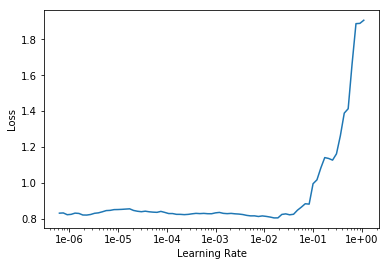

In [30]:
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(8, 1e-2)

epoch,train_loss,valid_loss,
1,0.394869,0.333526,0.848638
2,0.399089,0.348061,0.845525
3,0.381996,0.362003,0.837549
4,0.384769,0.315503,0.860311
5,0.358602,0.290945,0.874708
6,0.317507,0.273585,0.881323
7,0.300013,0.260113,0.884825
8,0.296131,0.257482,0.887354


In [31]:
name='res18-siamese'

In [32]:
learn.save(f'{name}-{SZ}-stage-1')

In [33]:
learn.unfreeze()

In [34]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


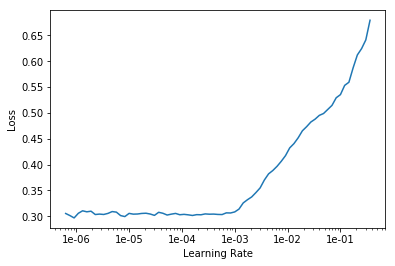

In [35]:
learn.recorder.plot()

In [36]:
learn.callback_fns.append(partial(SaveModel, every='improvement', name=f'{name}-{SZ}-stage-2'))

In [37]:
max_lr = 2e-4
lrs = slice(max_lr/90,max_lr)
learn.lr_range(lrs)

array([4.444444e-06, 4.216370e-05, 4.000000e-04])

In [38]:
#max_lr = 2e-4
#lrs = slice(max_lr/2,max_lr)
#learn.lr_range(lrs)

In [39]:
learn.fit_one_cycle(20, lrs) #4e-4 slice(max_lr/90,max_lr)

epoch,train_loss,valid_loss,
1,0.299767,0.251270,0.896303
2,0.294225,0.251491,0.899805
3,0.284724,0.251666,0.895720
4,0.279068,0.246982,0.896303
5,0.288432,0.250557,0.893385
6,0.275669,0.237743,0.906615
7,0.275012,0.232448,0.901167
8,0.267935,0.228184,0.908366
9,0.257373,0.225086,0.907977
10,0.246972,0.222342,0.914397


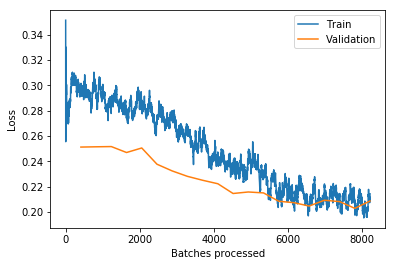

In [40]:
learn.recorder.plot_losses()

The model is not doing that well - out of presented pairs it gets roughly 10% of examples wrong. I also did a cursory error analysis (not shown here for the sake of brevity) and the model is not doing that great at all.

How can this be? Maybe the nearly absolute positional invariance through the use of global max pooling is not working that well. Maybe there is a bug somewhere? Maybe the model has not been trained for long enough or lacks capacity?

If I do continue to work on this I will definitely take a closer look at each of the angles I list above. For the time being, let's try to predict on the validation set and finish off with making a submission.

The predicting part is where the code gets really messy. That is good enough for now though.

## Size 512px

In [27]:
SZ = 512
BS = 12
NUM_WORKERS = 8

In [28]:
data = (
    ImageItemList
        .from_df(df[df.Id != 'new_whale'], f'data/train-{SZ}', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-{SZ}'))
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
)

In [29]:
train_dl = DataLoader(
    TwoImDataset(data.train),
    batch_size=BS,
    shuffle=True,
    num_workers=NUM_WORKERS
)
valid_dl = DataLoader(
    TwoImDataset(data.valid),
    batch_size=BS,
    shuffle=False,
    num_workers=NUM_WORKERS
)

In [30]:
data_bunch = ImageDataBunch(train_dl, valid_dl)

data_bunch.add_tfm(normalize_batch)

In [31]:
learn = Learner(data_bunch, SiameseNetwork(), loss_func=BCEWithLogitsFlat(), 
                metrics=[lambda preds, targs: accuracy_thresh(preds.squeeze(), targs, sigmoid=False)])

In [33]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])

In [34]:
learn.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): ReLU(inplace)
   (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace)
   (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [78]:
learn.freeze_to(-1)

In [79]:
learn.load(f'{name}-224-stage-2');

In [80]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


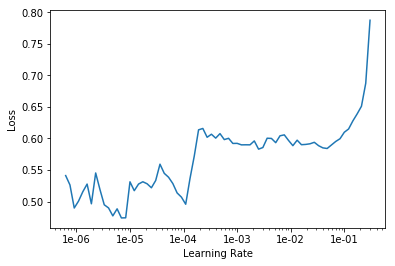

In [81]:
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,
1,0.380344,0.382574,0.807393
2,0.349238,0.311713,0.858366
3,0.300969,0.265244,0.890661
4,0.256871,0.240156,0.903696
5,0.222473,0.229188,0.903502


In [40]:
learn.save(f'{name}-{SZ}-stage-1')

In [41]:
learn.unfreeze()

In [42]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


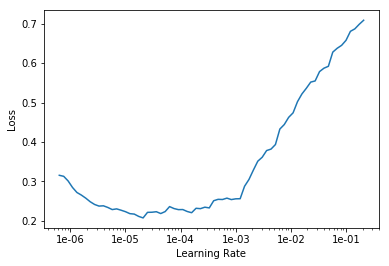

In [43]:
learn.recorder.plot()

In [44]:
learn.callback_fns.append(partial(SaveModel, every='improvement', name=f'{name}-{SZ}-stage-2'))

In [45]:
max_lr = 1e-4
lrs = slice(max_lr/9,max_lr)
learn.lr_range(lrs)

array([1.111111e-05, 3.333333e-05, 1.000000e-04])

In [46]:
learn.fit_one_cycle(20, lrs) #2e-4 slice(max_lr/2,max_lr)

epoch,train_loss,valid_loss,
1,0.252300,0.221609,0.903696
2,0.224977,0.219060,0.903696
3,0.196993,0.214520,0.911089
4,0.207484,0.218644,0.906615
5,0.207220,0.205823,0.915370
6,0.203244,0.201421,0.913619
7,0.182633,0.204772,0.919844
8,0.178336,0.196804,0.916537
9,0.186349,0.189587,0.920623
10,0.170740,0.190384,0.917899


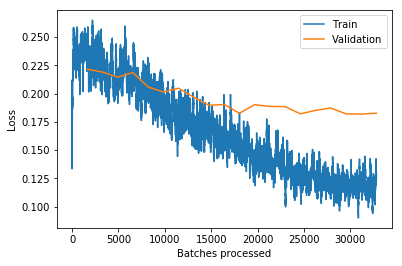

In [47]:
learn.recorder.plot_losses()

## validate 

In [72]:
name='res18-siamese'

In [73]:
learn.load(f'{name}-{SZ}-stage-2');

In [74]:
learn.model.eval();

In [75]:
new_whale_fns = set(df[df.Id == 'new_whale'].sample(frac=1).Image.iloc[:1000])

In [76]:
data = (
    ImageItemList
        .from_df(df, f'data/train-{SZ}', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns.union(new_whale_fns))
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-{SZ}'))
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

In [77]:
len(data.valid_ds)

3570

In [78]:
%%time
targs = []
feats = []
learn.model.eval()
for ims, ts in data.valid_dl:
    feats.append(learn.model.process_features(learn.model.cnn(ims)).detach().cpu())
    targs.append(ts)

CPU times: user 10.3 s, sys: 5.02 s, total: 15.3 s
Wall time: 15.6 s


In [79]:
feats = torch.cat(feats)

In [80]:
feats.shape

torch.Size([3570, 512])

In [81]:
%%time
sims = []
for feat in feats:
    dists = learn.model.calculate_distance(feats, feat.unsqueeze(0).repeat(3570, 1))
    predicted_similarity = learn.model.head(dists.cuda()).sigmoid_()
    sims.append(predicted_similarity.squeeze().detach().cpu())

CPU times: user 21.7 s, sys: 174 ms, total: 21.9 s
Wall time: 21.9 s


In [82]:
len(sims)

3570

In [83]:
new_whale_idx = np.where(classes == 'new_whale')[0][0]

In [84]:
%%time
top_5s = []
for i, sim in enumerate(sims):
    idxs = sim.argsort(descending=True)
    probs = sim[idxs]
    top_5 = []
    for j, p in zip(idxs, probs):
        if len(top_5) == 5: break
        if j == i: continue
        predicted_class = data.valid_ds.y.items[j]
        if j == predicted_class: continue
        if predicted_class not in top_5: top_5.append(predicted_class)
    top_5s.append(top_5)

CPU times: user 1.14 s, sys: 743 µs, total: 1.15 s
Wall time: 1.15 s


In [85]:
# without predicting new_whale
mapk(data.valid_ds.y.items.reshape(-1,1), np.stack(top_5s), 5)

0.4096405228758169

In [90]:
%%time

for thresh in np.linspace(0.98, 1, 21):
    top_5s = []
    for i, sim in enumerate(sims):
        idxs = sim.argsort(descending=True)
        probs = sim[idxs]
        top_5 = []
        for j, p in zip(idxs, probs):
            if new_whale_idx not in top_5 and p < thresh and len(top_5) < 5: top_5.append(new_whale_idx)
            if len(top_5) == 5: break
            if j == new_whale_idx or j == i: continue
            predicted_class = data.valid_ds.y.items[j]
            if predicted_class not in top_5: top_5.append(predicted_class)
        top_5s.append(top_5)
    print(thresh, mapk(data.valid_ds.y.items.reshape(-1,1), np.stack(top_5s), 5))

0.98 0.43020074696545285
0.981 0.43023342670401493
0.982 0.43153594771241827
0.983 0.43105975723622786
0.984 0.4317226890756303
0.985 0.4309897292250233
0.986 0.43054621848739494
0.987 0.43073295985060694
0.988 0.4300420168067227
0.989 0.4310971055088702
0.99 0.4326377217553688
0.991 0.4353781512605043
0.992 0.43580765639589175
0.993 0.43765172735760965
0.994 0.437796451914099
0.995 0.4373902894491129
0.996 0.43570494864612513
0.997 0.4375023342670401
0.998 0.4327777777777777
0.999 0.4302334267040149
1.0 0.4295798319327731
CPU times: user 26.3 s, sys: 7.78 ms, total: 26.3 s
Wall time: 26.3 s


In [91]:
mapk(data.valid_ds.y.items.reshape(-1,1), np.stack(top_5s), 5)

0.4295798319327731

There are many reasons why the best threshold here might not carry over to what would make sense on the test set. It is some indication though of how our model is doing and a useful data point.

## Predict

In [92]:
len(data.test_ds)

7960

In [93]:
data = (
    ImageItemList
        .from_df(df, f'data/train-{SZ}', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in {'69823499d.jpg'}) # in newer version of the fastai library there is .no_split that could be used here
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-{SZ}'))
        .transform(None, size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

In [94]:
%%time
test_feats = []
learn.model.eval()
for ims, _ in data.test_dl:
    test_feats.append(learn.model.head1(learn.model.process_features(learn.model.pool(learn.model.cnn(ims)))) \
                 .detach().cpu())

CPU times: user 19.3 s, sys: 10.8 s, total: 30.1 s
Wall time: 30.5 s


In [95]:
%%time
train_feats = []
train_class_idxs = []
learn.model.eval()
for ims, t in data.train_dl:
    train_feats.append(learn.model.head1(learn.model.process_features(learn.model.pool(learn.model.cnn(ims)))) \
                 .detach().cpu())
    train_class_idxs.append(t)

CPU times: user 1min 2s, sys: 33.8 s, total: 1min 35s
Wall time: 1min 36s


In [96]:
train_class_idxs = torch.cat(train_class_idxs)
train_feats = torch.cat(train_feats)

In [97]:
test_feats = torch.cat(test_feats)

In [98]:
%%time
sims = []
for feat in test_feats:
    dists = learn.model.calculate_distance(train_feats, feat.unsqueeze(0).repeat(25356, 1))
    predicted_similarity = learn.model.head(dists.cuda()).sigmoid_()
    sims.append(predicted_similarity.squeeze().detach().cpu())

CPU times: user 5min 15s, sys: 1min 53s, total: 7min 8s
Wall time: 7min 9s


In [99]:
%%time
thresh = 0.994 #1

top_5s = []
for sim in sims:
    idxs = sim.argsort(descending=True)
    probs = sim[idxs]
    top_5 = []
    for i, p in zip(idxs, probs):
        if new_whale_idx not in top_5 and p < thresh and len(top_5) < 5: top_5.append(new_whale_idx)
        if len(top_5) == 5: break
        if i == new_whale_idx: continue
        predicted_class = train_class_idxs[i]
        if predicted_class not in top_5: top_5.append(predicted_class)
    top_5s.append(top_5)

CPU times: user 21.5 s, sys: 507 ms, total: 22 s
Wall time: 22 s


In [100]:
top_5_classes = []
for top_5 in top_5s:
    top_5_classes.append(' '.join([classes[t] for t in top_5]))

In [101]:
top_5_classes[:5]

['new_whale w_dec7ffd w_d66d8f4 w_066ac1a w_242fb46',
 'new_whale w_cbda0d3 w_4132bb8 w_d72771c w_e3956f5',
 'w_d066c0a w_f64d347 new_whale w_24c76d8 w_94c3bf0',
 'w_a335fc2 w_9c506f6 new_whale w_488865e w_0abe9e7',
 'new_whale w_2cabd62 w_7e56d66 w_1082fdc w_a10e633']

In [102]:
sub = pd.DataFrame({'Image': [path.name for path in data.test_ds.x.items]})
sub['Id'] = top_5_classes
sub.to_csv(f'subs/{name}-{SZ}.csv.gz', index=False, compression='gzip')

In [103]:
pd.read_csv(f'subs/{name}-{SZ}.csv.gz').head()

,Image,Id
0,00028a005.jpg,new_whale w_dec7ffd w_d66d8f4 w_066ac1a w_242fb46
1,000dcf7d8.jpg,new_whale w_cbda0d3 w_4132bb8 w_d72771c w_e3956f5
2,000e7c7df.jpg,w_d066c0a w_f64d347 new_whale w_24c76d8 w_94c3bf0
3,0019c34f4.jpg,w_a335fc2 w_9c506f6 new_whale w_488865e w_0abe9e7
4,001a4d292.jpg,new_whale w_2cabd62 w_7e56d66 w_1082fdc w_a10e633


In [104]:
pd.read_csv(f'subs/{name}-{SZ}.csv.gz').Id.str.split().apply(lambda x: x[0] == 'new_whale').mean()

0.5071608040201006

In [ ]:
#public lb score: 0.469